2021.08.23 GPS點位轉成路網軌跡

In [45]:
# 資料處理
import pandas as pd
import numpy as np

# 日期時間處理
from datetime import datetime, timedelta, date

# 地理資料操作
import geopandas as gpd
import fiona
import sys
sys.path.append('G:\我的雲端硬碟\python')
from polib.MapToolkit import plot_points_on_folium

# 路網操作
from s2g import ShapeGraph
import networkx as nx
import osmnx as ox

# 繪圖
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

In [223]:
# 讀取GPS資料
GPS_path = r"G:\共用雲端硬碟\#全鋒SBIR\02 專案執行(工作項目)\03 執行規劃\最佳路徑、派遣邏輯演算\參考資料\過去數據參考資料_by全鋒\KLA-2626  1201-1210.xls"
GPS_df = pd.read_excel(GPS_path, skiprows=1)
GPS_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4695 entries, 0 to 4694
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   時間      4695 non-null   object 
 1   司機      4695 non-null   object 
 2   緯度      4695 non-null   float64
 3   經度      4695 non-null   float64
 4   定位狀態    4695 non-null   object 
 5   方向      4695 non-null   object 
 6   速度      4695 non-null   object 
 7   車輛狀態    4695 non-null   object 
 8   累積里程    4695 non-null   object 
 9   地址      4695 non-null   object 
dtypes: float64(2), object(8)
memory usage: 366.9+ KB


In [224]:
# 日期格式轉換
GPS_df.loc[:,"時間"] = GPS_df.loc[:,"時間"].apply(lambda sd:datetime.strptime("2020/" + sd, "%Y/%m/%d %H:%M:%S"))
GPS_df.loc[:,"日期"] = GPS_df.loc[:,"時間"].dt.date

In [241]:
print(len(GPS_df))
# 篩選單一日期 12/1
GPS_df = GPS_df[GPS_df["日期"].isin([date(2020,12,1)])].reset_index(drop=True)
print(len(GPS_df))

# 篩選特定時間
GPS_df = GPS_df[GPS_df["時間"].dt.hour.isin([10])].reset_index(drop=True)
print(len(GPS_df))

124
124
68


In [242]:
# df to gdf
GPS_gdf = gpd.GeoDataFrame(
    GPS_df, geometry=gpd.points_from_xy(GPS_df["經度"], GPS_df["緯度"]))


In [243]:
# 設定原始 CRS
GPS_gdf = GPS_gdf.set_crs("EPSG:4326")

In [244]:
plot_points_on_folium(GPS_gdf)

>> Start Maping...


# 將原始GPS 存成 KML 觀察

In [245]:
# 將原始GPS 存成 KML 觀察
GPS_gdf_for_output = GPS_gdf.copy(deep=True)

# 檢查型態
for c in GPS_gdf_for_output.columns[:-1]:
    print(c, GPS_gdf_for_output[c].map(type).unique())
    GPS_gdf_for_output.loc[:,c] = GPS_gdf_for_output.loc[:,c].astype(str)

# 存成KML 觀察
fiona.supported_drivers['KML'] = 'rw'
GPS_gdf_for_output.to_file(
                'GPS_gdf.kml', encoding='utf8', driver='KML')

ERROR:fiona._env:`GPS_gdf.kml' not recognized as a supported file format.


時間 [<class 'pandas._libs.tslibs.timestamps.Timestamp'>]
司機 [<class 'str'>]
緯度 [<class 'float'>]
經度 [<class 'float'>]
定位狀態 [<class 'str'>]
方向 [<class 'str'>]
速度 [<class 'str'>]
車輛狀態 [<class 'str'>]
累積里程 [<class 'str'>]
地址 [<class 'str'>]
日期 [<class 'datetime.date'>]


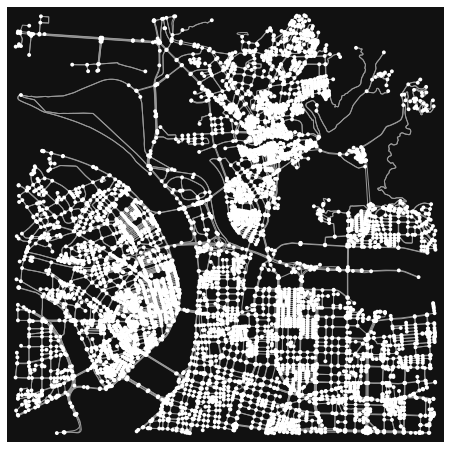

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [89]:
# 讀取路網圖資料(OSM)
G = ox.graph_from_point((GPS_gdf["緯度"].median() , GPS_gdf["經度"].median()), dist=5000, network_type='drive')
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G) # 取得各 節點 線段 資訊
ox.plot_graph(G) # 會跑一小陣子

# 計算GPS點最近節點

In [246]:
from tqdm import tqdm
# 計算GPS點最近節點
GPS_nearest_nodes_lst = []
print(len(GPS_gdf))
for y,x in tqdm(zip(GPS_gdf["緯度"],GPS_gdf["經度"])):
    GPS_nearest_nodes =  ox.distance.nearest_nodes(G, Y=y, X=x)
    GPS_nearest_nodes_lst.append(GPS_nearest_nodes)


68


68it [00:05, 13.48it/s]


# 依序 排除重複 nodes

In [247]:
# 依序 排除重複 nodes
GPS_nearest_nodes_dedup_lst = []
for n in GPS_nearest_nodes_lst:
    
    if len(GPS_nearest_nodes_dedup_lst)>0:
        if n == GPS_nearest_nodes_dedup_lst[-1]:
            pass
        else:
            GPS_nearest_nodes_dedup_lst.append(n)
    else:
        GPS_nearest_nodes_dedup_lst.append(n)

print(len(GPS_nearest_nodes_dedup_lst))

42


In [248]:
iso_colors = ox.plot.get_colors(n=1, cmap='Reds', start=0.3, return_hex=True)
iso_colors[0]

'#fcab8f'

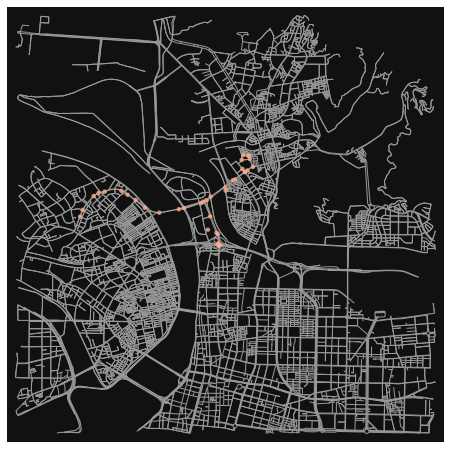

In [249]:
node_colors = {}
for node in GPS_nearest_nodes_dedup_lst:
    node_colors[node] = iso_colors[0] # 抵達的node給顏色
        
# 根據上面抵達的node給顏色，並畫圖
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)

In [297]:
df_nearest_nodes['street_count'].value_counts()

3    32
4     8
5     1
1     1
Name: street_count, dtype: int64

In [282]:
# 將最近 點位 存成 gdf
df_nearest_nodes = pd.DataFrame()
for nn in GPS_nearest_nodes_dedup_lst:
    df_nearest_nodes = pd.concat([df_nearest_nodes, gdf_nodes.loc[nn]], axis=1)

df_nearest_nodes = df_nearest_nodes.transpose()

# 檢查型態
for c in df_nearest_nodes.columns:
    print(c, df_nearest_nodes[c].map(type).unique())
    df_nearest_nodes.loc[:,c] = df_nearest_nodes.loc[:,c].astype(str)

# df to gdf
gdf_nearest_nodes = gpd.GeoDataFrame(
    df_nearest_nodes, geometry=gpd.points_from_xy(df_nearest_nodes["x"], df_nearest_nodes["y"]))

print(gdf_nearest_nodes.info())


# 存成KML(方便檢查)
fiona.supported_drivers['KML'] = 'rw'

gdf_nearest_nodes.drop_duplicates().to_file('gdf_nearest_nodes.kml', driver='KML')

ERROR:fiona._env:`gdf_nearest_nodes.kml' not recognized as a supported file format.


y [<class 'numpy.float64'>]
x [<class 'numpy.float64'>]
street_count [<class 'numpy.int64'>]
highway [<class 'str'> <class 'float'>]
ref [<class 'float'>]
geometry [<class 'shapely.geometry.point.Point'>]
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 42 entries, 2246305246 to 623657144
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   y             42 non-null     object  
 1   x             42 non-null     object  
 2   street_count  42 non-null     object  
 3   highway       42 non-null     object  
 4   ref           42 non-null     object  
 5   geometry      42 non-null     geometry
dtypes: geometry(1), object(5)
memory usage: 2.3+ KB
None


In [367]:
df_nearest_nodes

,y,x,street_count,highway,ref,geometry
2246305246,25.0838156,121.4810838,4,traffic_signals,nan,POINT (121.48108 25.08382)
1218006895,25.0852547,121.4816732,3,traffic_signals,nan,POINT (121.48167 25.08525)
2207909374,25.0882317,121.4842766,3,traffic_signals,nan,POINT (121.48428 25.08823)
6897678645,25.0888783,121.4854337,3,nan,nan,POINT (121.48543 25.08888)
2249908844,25.0891655,121.4868939,3,nan,nan,POINT (121.48689 25.08917)
1215995617,25.0893528,121.49083,3,nan,nan,POINT (121.49083 25.08935)
2207940782,25.0885086,121.4922892,3,nan,nan,POINT (121.49229 25.08851)
3349564644,25.0873888,121.4941841,3,nan,nan,POINT (121.49418 25.08739)
5320195127,25.0857117,121.496354,3,nan,nan,POINT (121.49635 25.08571)
662278660,25.0846576,121.4998007,3,nan,nan,POINT (121.49980 25.08466)


## 道路左右側方向打錯會嚴重影響路線!!

# 以 nodes 每段起訖點 計算排序 route

In [283]:
# 以 nodes 每段起訖點 計算排序 route
edge_lst = []
for i in range(len(GPS_nearest_nodes_dedup_lst)-1):
    edge_lst.append((GPS_nearest_nodes_dedup_lst[i],GPS_nearest_nodes_dedup_lst[i+1]))

route_lst = []
print(len(edge_lst))
for e in tqdm(edge_lst):
    try:
        route_lst.append(nx.shortest_path(G, e[0], e[1], weight="length"))
    except Exception as e:
        print(e)
print(len(route_lst))

41


100%|████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 1783.59it/s]

No path to 623657498.
40


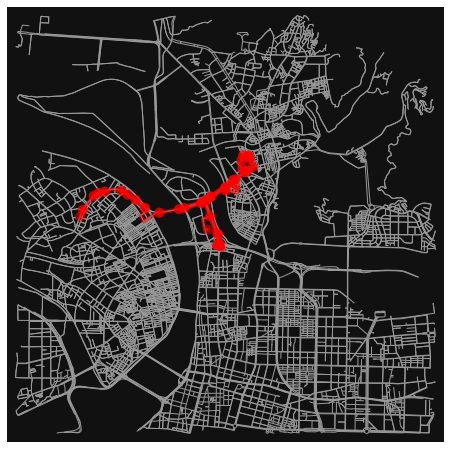

In [284]:
# routes = [route1, route2, route3]
# rc = ['r', 'y', 'c']

# 劃出路線 需要跑一小陣子
fig, ax = ox.plot_graph_routes(G, route_lst, 
#                                route_colors=rc, 
                               route_linewidth=0.5, 
                               node_size=0
                              )

# 將路線 點位存成 gdf

In [293]:
df_nodes_on_routes["highway"].value_counts()

traffic_signals    89
Name: highway, dtype: int64

In [295]:
# 將 路線 點位存成 gdf
df_nodes_on_routes = pd.DataFrame()
for route in route_lst:
    df_nodes_on_routes = pd.concat([df_nodes_on_routes, gdf_nodes.loc[route]])
    
# df to gdf
gdf_nodes_on_routes = gpd.GeoDataFrame(
    df_nodes_on_routes, geometry=gpd.points_from_xy(df_nodes_on_routes["x"], df_nodes_on_routes["y"]))

print(gdf_nodes_on_routes.info())

# 存成KML(方便檢查)
fiona.supported_drivers['KML'] = 'rw'

gdf_nodes_on_routes.drop_duplicates().to_file('gdf_nodes_on_routes.kml', driver='KML')

ERROR:fiona._env:`gdf_nodes_on_routes.kml' not recognized as a supported file format.


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 222 entries, 2246305246 to 623657144
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   y             222 non-null    float64 
 1   x             222 non-null    float64 
 2   street_count  222 non-null    int64   
 3   highway       89 non-null     object  
 4   ref           0 non-null      object  
 5   geometry      222 non-null    geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 12.1+ KB
None


In [368]:
df_nodes_on_routes

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
2246305246,25.083816,121.481084,4,traffic_signals,NaN,POINT (121.48108 25.08382)
1215995629,25.085070,121.481686,3,traffic_signals,NaN,POINT (121.48169 25.08507)
1218007861,25.085214,121.481761,4,traffic_signals,NaN,POINT (121.48176 25.08521)
1218006895,25.085255,121.481673,3,traffic_signals,NaN,POINT (121.48167 25.08525)
1218006895,25.085255,121.481673,3,traffic_signals,NaN,POINT (121.48167 25.08525)
...,...,...,...,...,...,...
623657122,25.078154,121.513803,3,NaN,NaN,POINT (121.51380 25.07815)
623657201,25.077935,121.513801,3,NaN,NaN,POINT (121.51380 25.07794)
623657258,25.077781,121.513536,3,NaN,NaN,POINT (121.51354 25.07778)


# 將路線 線段 存成 gdf

In [414]:
# 將路線 線段 存成 gdf
df_edges_on_routes = pd.DataFrame()
for route in route_lst:
    for u,v in zip(route, route[1:]):
        df_edges_on_routes = pd.concat([df_edges_on_routes, gdf_edges.loc[u, v, 0]], axis=1)

df_edges_on_routes = df_edges_on_routes.transpose()

# 檢查型態
col_lst = df_edges_on_routes.columns.to_list()
col_lst.remove("geometry")
for c in col_lst:
    print(c, df_edges_on_routes[c].map(type).unique())
    df_edges_on_routes.loc[:,c] = df_edges_on_routes.loc[:,c].astype(str)

# df to gdf
gdf_edges_on_routes = gpd.GeoDataFrame(
    df_edges_on_routes, geometry=df_edges_on_routes["geometry"])

print(gdf_edges_on_routes.info())

# 存成KML(方便檢查)
fiona.supported_drivers['KML'] = 'rw'
gdf_edges_on_routes.reset_index(drop=True).to_file(
                'gdf_edges_on_routes.kml', driver='KML')

In [415]:
gdf_edges_on_routes

,osmid,name,highway,oneway,length,maxspeed,geometry,lanes,bridge,ref,junction,access,tunnel,service,width
"(2246305246, 1215995629, 0)",335596334,集賢路,secondary,True,152.34199999999998,nan,"LINESTRING (121.48108 25.08382, 121.48109 25.0...",nan,nan,103甲,nan,nan,nan,nan,nan
"(1215995629, 1218007861, 0)",335596334,集賢路,secondary,True,17.723,nan,"LINESTRING (121.48169 25.08507, 121.48176 25.0...",nan,nan,103甲,nan,nan,nan,nan,nan
"(1218007861, 1218006895, 0)",105778444,重陽二街,residential,False,9.913,nan,"LINESTRING (121.48176 25.08521, 121.48167 25.0...",nan,nan,nan,nan,nan,nan,nan,nan
"(1218006895, 1218007861, 0)",105778444,重陽二街,residential,False,9.913,nan,"LINESTRING (121.48167 25.08525, 121.48176 25.0...",nan,nan,nan,nan,nan,nan,nan,nan
"(1218007861, 3722820113, 0)",335596334,集賢路,secondary,True,159.711,nan,"LINESTRING (121.48176 25.08521, 121.48180 25.0...",nan,nan,103甲,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(662278866, 623657498, 0)",51903924,重慶北路四段,primary,True,416.404,50,"LINESTRING (121.51181 25.08386, 121.51209 25.0...",3,nan,2乙,nan,nan,nan,nan,nan
"(623657498, 623657122, 0)",444996950,重慶北路四段,primary,True,255.26999999999998,50,"LINESTRING (121.51329 25.08037, 121.51348 25.0...",3,nan,2乙,nan,nan,nan,nan,nan
"(623657122, 623657201, 0)",857513615,重慶北路四段,primary,True,24.309,50,"LINESTRING (121.51380 25.07815, 121.51380 25.0...",3,nan,2乙,nan,nan,nan,nan,nan
"(623657201, 623657258, 0)",49164270,台北交流道,motorway_link,True,288.751,nan,"LINESTRING (121.51380 25.07794, 121.51371 25.0...",nan,nan,nan,nan,nan,nan,nan,nan


In [362]:
# # (option)時間動畫

# features = [{
#     'geometry': {
#         'coordinates': list(row['geometry'].coords),
#         'type': 'Point'
#     },
#     'properties': {
#         'icon': 'marker',
#         'iconstyle': {
#             'iconSize': [40, 40],
#             'iconUrl':
#             'https://www.flaticon.com/svg/vstatic/svg/664/664468.svg?token=exp=1616138018~hmac=c04c6983e10730773e5f5f124f7b42e5'
#         },
#         'id': None,
#         'popup': 1,
#         'times': [row["時間"].strftime("%Y-%m-%dT %H:%M:%S")] #'YYYY/MM/DD HH:mm:ss'
# #         'times': [str(row["時間"]).astype(str)]
#     },
#     'type': 'Feature'
# }
#     for idx,row in GPS_gdf.iterrows()
# ]

In [363]:
# features

In [366]:
# map = folium.Map(location=[23.762485, 120.827323], 
#                  zoom_start=8, 
#                  tiles='http://tile.stamen.com/toner/{z}/{x}/{y}.png', 
#                  attr="https://stackoverflow.com/questions/48318538/folium-custom-map-tiles"
#                 )

# # 車完整路線
# folium.Choropleth(
#     LineString(GPS_gdf.geometry.to_list()),
#     line_weight=3,
#     line_color='#66B3FF',
#     name="GPS 點位"
# ).add_to(map)
    
# # (option)加入時間
# plugins.TimestampedGeoJson(
#         {'type': 'FeatureCollection',
#         'features': features}
#         , period='PT1' 
# #         , duration='PT1M'
# #         , add_last_point=False
# #         , auto_play=True
# #         , loop=False
# #         , max_speed=1
# #         , loop_button=True
#         , date_options='YYYY/MM/DD HH:mm:ss'
# #         , time_slider_drag_update=True
#     ).add_to(map)

# # 加入底圖
# folium.raster_layers.TileLayer(
#     tiles = "https://wmts.nlsc.gov.tw/wmts/PHOTO2/default/GoogleMapsCompatible/{z}/{y}/{x}",                 
#     attr = "國土測繪圖資服務雲",
#     name="正射影像圖(通用版)",
# #     overlay=True,
#     min_zoom=0,
#     max_zoom=19,
#     ).add_to(map)
# # folium.LayerControl().add_to(map)


# folium.raster_layers.TileLayer(
#     tiles = "https://wmts.nlsc.gov.tw/wmts/EMAP2/default/GoogleMapsCompatible/{z}/{y}/{x}",                 
#     attr = "國土測繪圖資服務雲",
#     name="臺灣通用電子地圖透明",
#     show=False,
#     overlay=True,
#     min_zoom=0,
#     max_zoom=19,
#     ).add_to(map)
# folium.LayerControl().add_to(map)

# map